# Co robimy dziś
Dzisiaj wgracie pozycję elektrod, zobaczycie ich pozycję w różnych wizualizacjach, a następnie zobaczycie jak reprezentowane są wydarzenia w `mne` oraz jak poepokować sygnał. Po epokowaniu zobaczymy jak wyglądają ERPy i zasmuci nas zapewne zaśmiecenie erpa artefaktami ocznymi. Aby usunąć artefakty oczne wykorzystamy `ICA` - analizę niezależnych komponentów. Jeżeli starczy nam dziś czasu
to przejrzymy komponenty, usuniemy komponenty odpowiedzialne za artefakty oczne, a następnie zobaczymy jak zmienił nam się potencjał wywołany.

## Na początek
Upewnij się na samym początku, że masz `mne` up to date (normalnie nie musisz tego robić, ale będziemy przy ICA potrzebowali funkcjonalności, która została dodana do mne 20-kilka dni temu, więc na wszelki wypadek dobrze zupgrade'ować).
Aby to zrobić wejdź z poziomu konsoli/cmder do folderu, do którego instalowałeś/instalowałaś mne.
Jeżeli nie pamiętasz jaki to folder możesz to sprawdźić w notebook'u:
```python
import mne
mne.__file__
```
Po wejściu do tego folderu wykonaj komendę:
```
git pull
```
ta komenda sprawi, że Twoja instalacja `mne` zostanie zupdate'owana.
Jeżeli importowałaś(/łeś) w notebook'u już mne aby sprawdzić gdzie mne jest na dysku - musisz zrestartować notebook (aby móc wczytać podczas importu zupgrade'owane mne). Restartujesz notebook klikając na menu `Kernel` na górze a następnie `Restart` i `OK`.

## Wczytywanie pliku
Tym razem wczytamy dane zarejestrowane na innym sprzęcie - czepku EGI. Normalnie do wczytywania tego rodzaju plików użylibyście funkcji `mne.io.read_raw_egi`, ale ze względu na moją niezmierną (a może i niemierzalną) życzliwość - wczytacie plik, który jest już przefiltrowany i ma zaznaczone artefakty.
Filtrowanie było wykonane górnoprzepustowym filtrem 0.5 Hz z low transition bandwidth ustawionym na 0.25 Hz. Po filtrowaniu i zaznaczeniu aftefaktów zapisałem plik w domyślnym formacie `mne` - `*.fif`.
Dlatego do wczytania tego pliku będziecie korzystać z funkcji `mne.io.read_raw_fif`.
Dane znajdziecie na naszym dropboxie (aktywny link na repozytorium w pliku `materiały.md`) w folderze `zajecia 04`.

Oczywiście potrzebne nam będą biblioteki `os` oraz `mne`, więc zaimportujemy je:

In [2]:
import os
import mne

Włączymy też do wykresów tryb interaktywny:

In [10]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [15]:
# tutaj ustawcie sobie zmienną z folderem do którego ściągneliście dane
# na dzisiejsze zajęcia:
data_dir = r'C:\Users\swps\Dropbox\Sarenka\ZAJECIA\AnalizaDanychEEG\zajecia 04'

In [16]:
cd $data_dir

C:\Users\swps\Dropbox\Sarenka\ZAJECIA\AnalizaDanychEEG\zajecia 04


In [17]:
ls

 Volume in drive C is Windows7_OS
 Volume Serial Number is 3435-68DE

 Directory of C:\Users\swps\Dropbox\Sarenka\ZAJECIA\AnalizaDanychEEG\zajecia 04

2017-03-23  16:48    <DIR>          .
2017-03-23  16:48    <DIR>          ..
2017-03-23  16:48            20˙352 CAT101_events.txt
2017-03-23  16:47        60˙770˙965 CAT101-raw.fif
               2 File(s)     60˙791˙317 bytes
               2 Dir(s)  14˙656˙290˙816 bytes free


Interesuje nas plik `CAT101-raw.fif`, wczytajmy go:

In [18]:
eeg = mne.io.read_raw_fif('CAT101-raw.fif', preload=True)

Opening raw data file C:\Users\swps\Dropbox\Sarenka\ZAJECIA\AnalizaDanychEEG\zajecia 04\CAT101-raw.fif...
Isotrak not found
    Range : 0 ... 208042 =      0.000 ...   832.168 secs
Ready.
Annotation expanding outside the data range. Limiting to the end of data.
Reading 0 ... 208042  =      0.000 ...   832.168 secs...


<ipython-input-18-0f17d8c4a9e2>:1: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  eeg = mne.io.read_raw_fif('CAT101-raw.fif', preload=True)


In [19]:
%matplotlib inline

Zobaczcie, że w pliku są już oznaczenia:

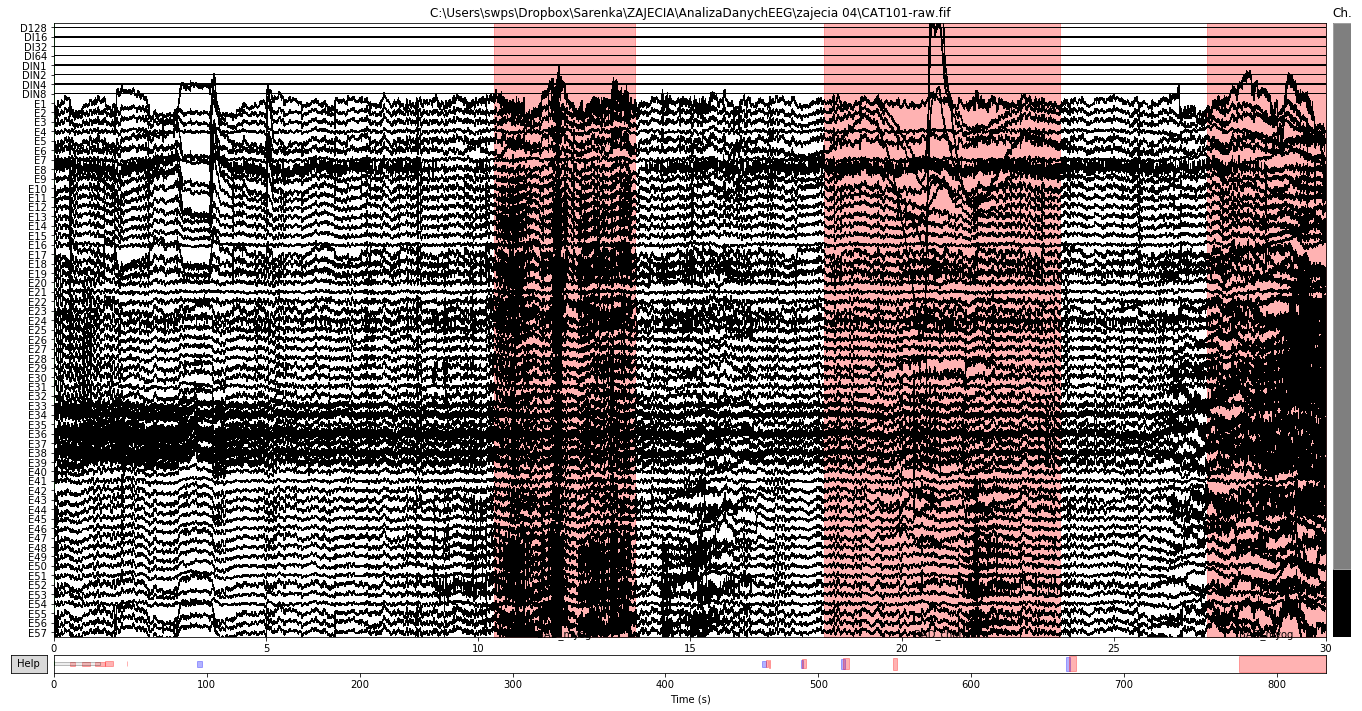

In [21]:
eeg.plot(n_channels=65, duration=30.);

Potrzebujemy jeszcze wgrać pozycję kanałów do naszych danych (bardzo się nam później przyda).
Robimy to:
* najpierw wczytując montaż (pozycję kanałów)
* następnie aplikując montaż do naszych danych
A po drodze jeszcze wyświetlimy sobie montaż aby obejrzeć pozycję kanałów w przestrzeni.
Aby wczytać montaż musimy znać jego nazwę. Waszym zadaniem jest znaleźć tę nazwę w dokumentacji funkcji [`mne.channels.read_montage`](http://martinos.org/mne/dev/generated/mne.channels.read_montage.html). Wystarczy Wam wiedzieć, że używaliśmy czepka Geodesic HydroCel z 64 kanałami plus elektrodą Cz. Gdy znajdziecie te nazwę umieśćcie ją w zmiennej `montage_type`.

In [22]:
# tutaj umieszczacie nazwę montażu w zmiennej

In [23]:
montage_type = 'GSN-HydroCel-65_1.0'

Teraz możmy wczytać montaż korzystając ze zmiennej `montage_type`:

In [24]:
montage = mne.channels.read_montage(montage_type)

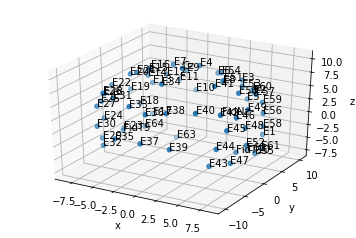

In [26]:
montage.plot(show_names=True);

To może nie jest najbardziej klarowny wykres, zobaczycie ładniejszy gdy zaaplikujecie pozycję kanałów do danych za pomocą `eeg.set_montage`:

In [27]:
eeg.set_montage(montage)

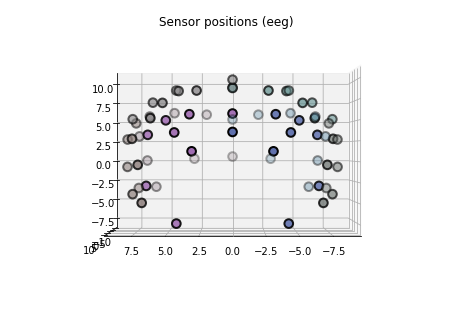

In [29]:
eeg.plot_sensors(kind='3d', ch_groups='position');

Poobracajcie sobie tym wykresem chwilę, sprawdźcie też nazwy elektrod, klikając na nie.

Następnie zajmiemy się wydarzeniami oraz epokowaniem. Aby poepokować dane musimy wiedzieć dokładnie kiedy co się wydarzyło. W danych różnie kodowane są momenty wystąpienia wydarzeń - w przypadku EGI mamy dodatkowe kanały reprezentujące wydarzenia binarnie: `DIN1`, `DIN2`, `DIN4`, `DIN8`, `DI16`, `DI32` itd.
Poniżej zrobimy sobie kopię danych, z tej kopii wybierzemy kanały DIN, a następnie wyświetlimy je:

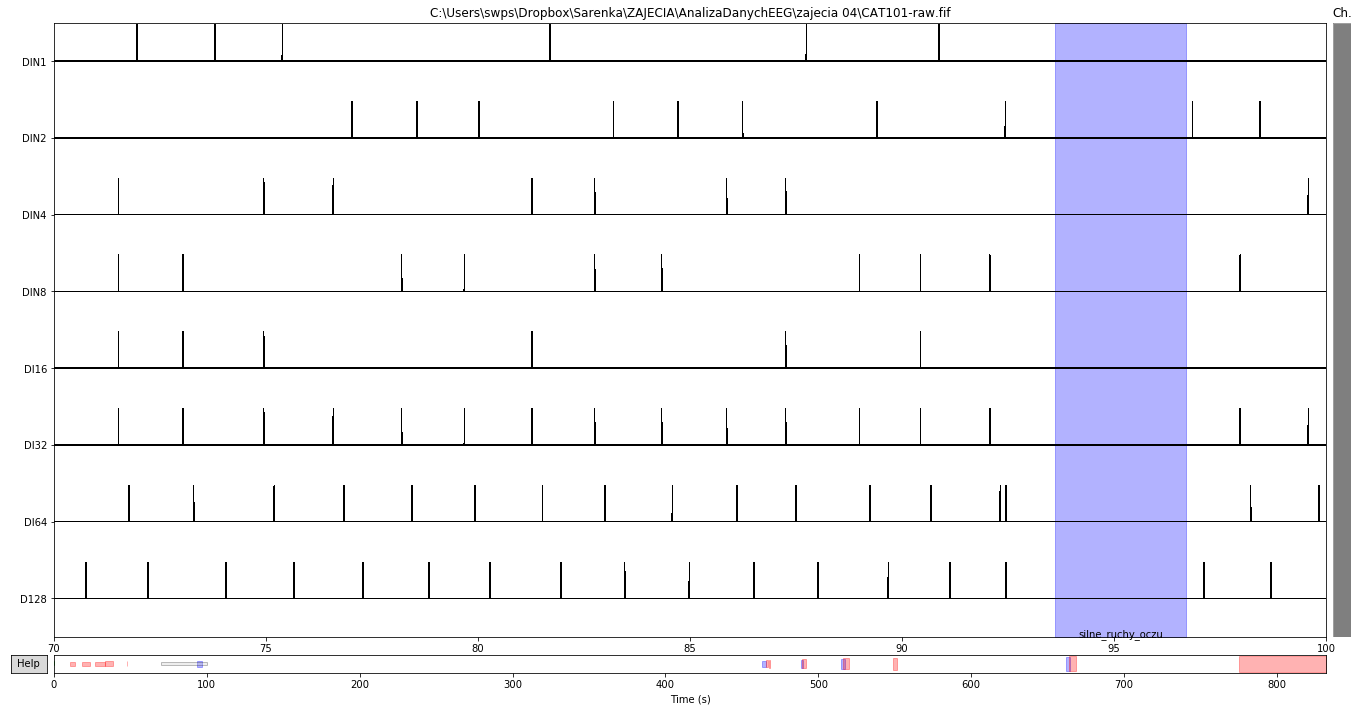

In [33]:
din_channels = ['DIN1', 'DIN2', 'DIN4', 'DIN8', 'DI16', 'DI32', 'DI64', 'D128']
eeg_din_channels = eeg.copy().pick_channels(din_channels)
eeg_din_channels.plot(n_channels=8, start=70., duration=30.);

Widzicie te igiełki? To binarna reprezentacja numerów wydarzeń. Co to znaczy?
Jeżeli w tym samym czasie mamy igiełkę na kanałach 'DIN4', 'DIN8', 'DI16', 'DI32' to otrzymujemy wartość numeryczną wydarzenia sumując wartości tych kanałów tzn. `4 + 8 + 16 + 32`.

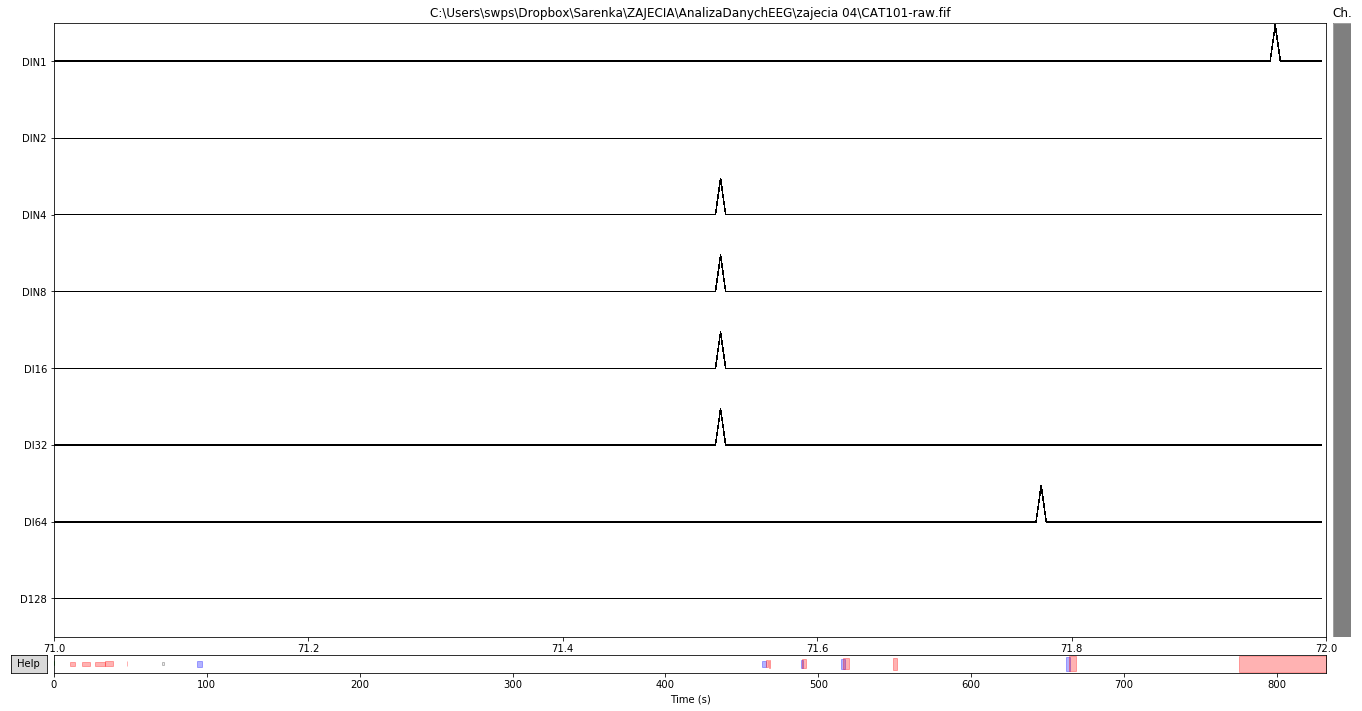

In [34]:
eeg_din_channels.plot(n_channels=8, start=71., duration=1.);

Możecie sobie to policzyć w pythonie:

In [35]:
4 + 8 + 16 + 32

60

A więc mamy wtedy wydarzenie o wartości `60`. Co to znaczy? To już zależy od tego jak ktoś napisał eksperyment. Nie wchodząc w detale poniżej macie tabelkę tego, co oznaczają poszczególne wartości wydarzeń:
* `1` - osoba badana wciska strzałkę w lewo
* `2` - osoba badana wciska strzałkę w prawo
* `3` - osoba badana wciska spację
* `36` - na ekranie prezentowany jest samochód pod kątem 0 stopni
* `40` - na ekranie prezentowany jest samochód pod kątem 90 stopni
* `44` - na ekranie prezentowany jest samochód pod kątem 180 stopni (do góry "nogami")
* `52` - na ekranie prezentowana jest twarz pod kątem 0 stopni
* `56` - na ekranie prezentowana jest twarz pod kątem 90 stopni
* `60` - na ekranie prezentowana jest twarz pod kątem 180 stopni (do góry nogami)
* `128` - na erkanie pojawia się krzyżyk fiksacji
I jeszcze kilka innych wydarzń, które nie są tak ważne.

Abyśmy mogli skorzystać z tych wydarzeń musimy znaleźć współwystępujące wydarzenia na kanałach `DIN` i dodać do siebie ich wartości. Nie musicie tego całe szczęście robić ręcznie - w `mypy` mam do tego funkcję: `mypy.events.re

In [36]:
import mypy

In [37]:
events = mypy.events.get_events_from_din(eeg)

Teraz możemy już usunąć kanały typu `DIN` - możemy do tego skorzystać z metody `drop_channels`.
Pamiętajcie, że mamy już zmienną `din_channels`, w której mamy listę nazw kanałów `DIN`:

In [38]:
din_channels

['DIN1', 'DIN2', 'DIN4', 'DIN8', 'DI16', 'DI32', 'DI64', 'D128']

Podamy tę listę kanałów metodie `drop_channels` aby się ich pozbyć:

In [39]:
eeg.drop_channels(din_channels)

<Raw  |  CAT101-raw.fif, n_channels x n_times : 65 x 208043 (832.2 sec), ~103.3 MB, data loaded>

W polu `eeg.ch_names` są nazwy kanałów. Możemy sprawdzić czy nie ma już w nich np. kanału `DIN4` tak:

In [40]:
'DIN4' in eeg.ch_names

False

`False` oznacza, że nie ma już tego kanału w danych.

Zobaczymy teraz co znajduje się w wydarzeniach, które przetrzymujemy w zmiennej `events`:

In [41]:
events

array([[ 14166,      0,    192],
       [ 14578,      0,      2],
       [ 14581,      0,    192],
       ..., 
       [192864,      0,     44],
       [192927,      0,     64],
       [193036,      0,      2]])

Cóż to takiego jest? To macierz - taka tablica wartości, która ma wiersze i kolumny.
Możecie adresować macierze podobnie jak listy. Element na przecięciu wiersza 5 i kolumny 3 adresujemy tak:

In [43]:
events[4, 2]

192

Ok, ale co my mamy w tej macierzy?
W pierwszej kolumnie mamy numery próbek sygnału, w których jest jakieś wydarzenie:

In [44]:
events[:, 0] # dwukropek znaczy - wszystko - tutaj cała pierwsza kolumna

array([ 14166,  14578,  14581, ..., 192864, 192927, 193036])

W trzeciej kolumnie mamy natomiast numeryczną wartość wydarzenia:

In [45]:
events[:, -1] # -1 to ostatni - tutaj ostatnia kolumna (cała - bo dwukropek w wierszach)

array([192,   2, 192, ...,  44,  64,   2])

Mamy ograniczony podgląd (część wartości zastępowanych jest wielokropkiem: `...`) aby nie zalało nam ekranu.

Zanim zabierzemy się za epokowanie wyświetlimy sobie wydarzenia w sygnale w jednolitym kolorze:

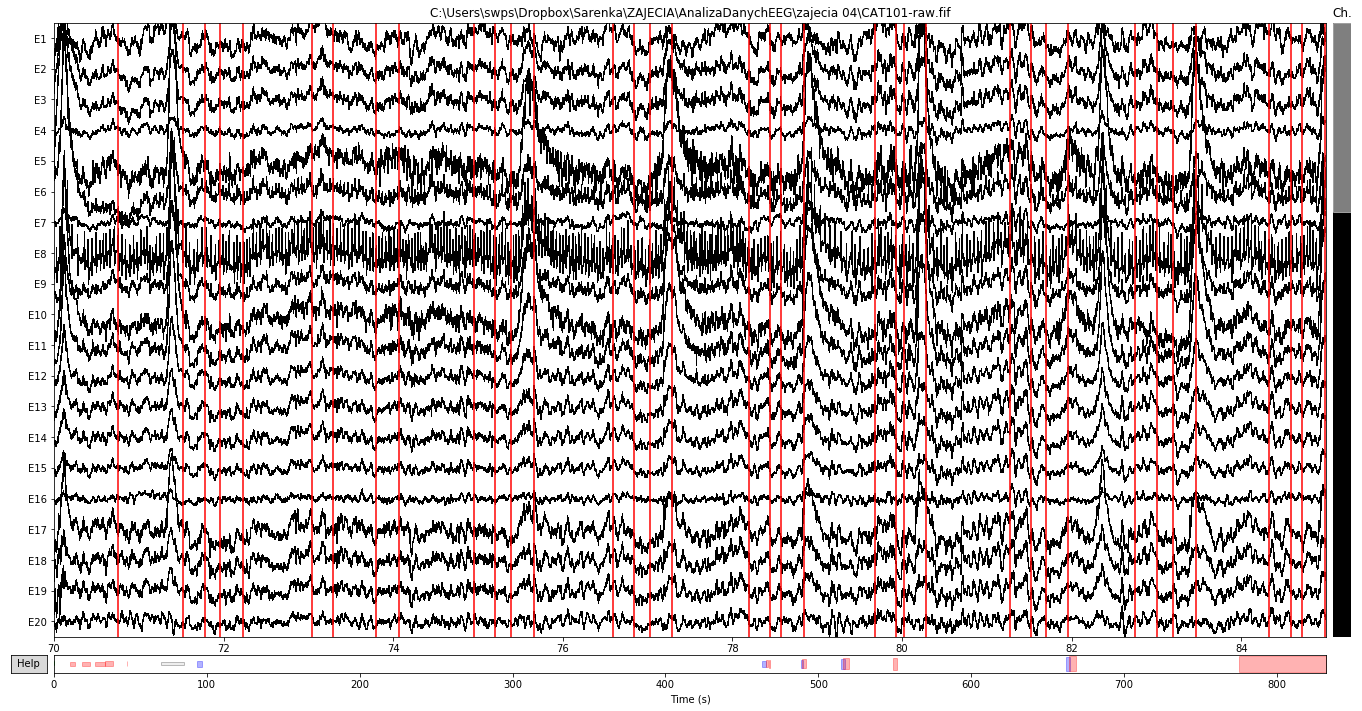

In [47]:
eeg.plot(events=events, event_color='red', start=70., duration=15.);

Pamiętajcie, że nie wszystkie wydarzenia to prezentacja bodźca: widzimy zgrupowania 4 wydarzeń (4 czerwone linie blisko siebie), które powinny odpowiadać sekwencji:
* prezentacja krzyżyka fiksacji
* prezentacja twarzy/samochodu
* zniknięcie twarzy/samochodu z ekranu
* odpowiedź osoby badanej (naciśnięcie klawisza)

Bardziej klarowne byłoby to gdybyśmy oddzielne typy wydarzń wyświetlali różnymi kolorami. Nie będziemy się jednak w to na razie bawić. Czas poepokować dane. Epokujemy korzystając z `mne.Epochs`, ale będziemy potrzebowali podać tej funkcji szereg argumentów: `tmin`, `tmax`, `events`, `event_id` oraz  `preload`. Sprawdźcie sobie dokumnetację `mne.Epochs` [tutaj](http://martinos.org/mne/dev/generated/mne.Epochs.html).

Zanim poepokujemy sygnał zdecydujemy się względem jakich wydarzeń chcemy epokować. Chcemy epokować względem prezentacji bodźców (twarzy oraz samochodów). Umieść w zmiennej `bodźce` listę wartości numerycznych wydarzeń będących prezentacją twarzy bądź samochodu (niezależnie od kątu obrotu bodźca). Poniżej przykład zakładający, że wydarzenia te mają wartość 1, 2 oraz 3 (nie jest tak - musisz to poprawić):

In [48]:
bodźce = [1, 2, 3]

Ok, teraz poepokujemy dane. Będziemy wycinać wygnał od 200 ms przed przezentacją bodźca (`tmin=-0.2`) aż do 500 ms po prezentacji bodźca (`tmax=0.5`). Podamy naszą listę `bodźce` jako `event_id` (sprawdź w dokumentacji co to) oraz wydarzenia z macierzy `events`. Skorzystamy też z opcji `preload=True` aby mieć wczytane dane.

In [50]:
epoki = mne.Epochs(eeg, events=events, event_id=bodźce,
                   tmin=-0.2, tmax=0.5, preload=True)

407 matching events found
0 projection items activated
Loading data for 407 events and 176 original time points ...
3 bad epochs dropped


Zauważcie napis `3 bad epochs dropped` - trzy epoki zostały odrzucone ze względu na oznaczone złe odcinki sygnału. Epoki nachodzące na złe odcinki są automatycznie odrzucane.

Aby przejrzeć sobie poepokowany sygnał korzystacie z jego metody `plot`:

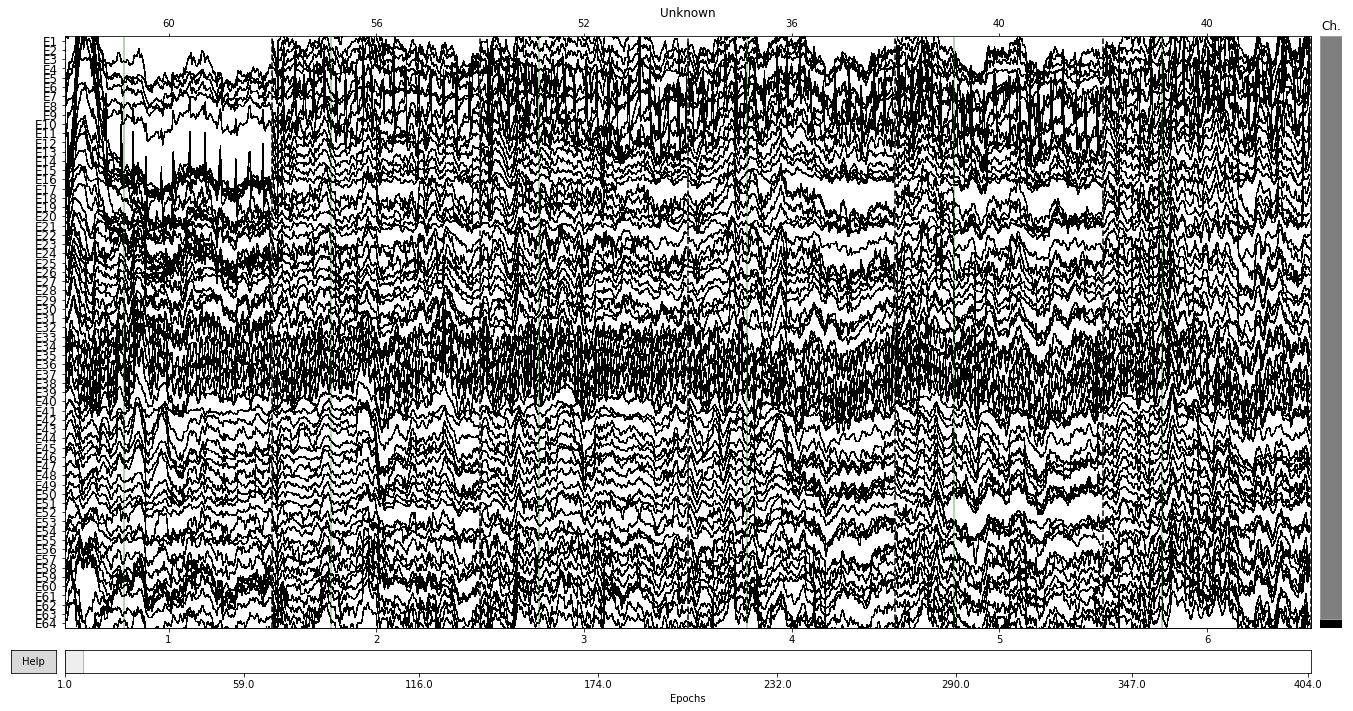

In [51]:
epoki.plot(n_channels=64, n_epochs=6);

Widzimy spore wahania sygnału w epokach (artefakty spowodowane ruchem oczu). Na razie nie przejmujmy się nimi, zobaczymy jak wygląda średnia reakcja na bodźiec (niezależnie od rodzaju bodźca):

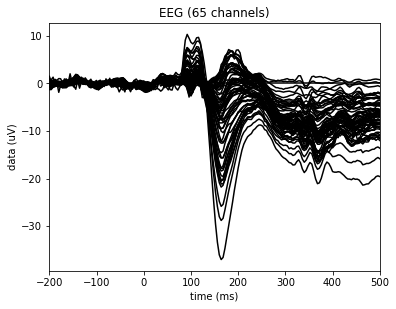

In [52]:
erp = epoki.average()
erp.plot();

W okienku, które wyskoczy możecie zaznaczać sobie fragmenty sygnału aby uzyskać topografię napięcia na skalpie. Zaznaczcie sobie sygnał mniej więcej między 350 a 450 ms - zobaczycie, że mamy w średniej reakcji znaczny wkład artefaktów ocznych.
Aby sobie z tym poradzić skorzystamy z ICA.
Ale zanim skorzystamy z ICA, jeszcze jeden ładny obrazek:

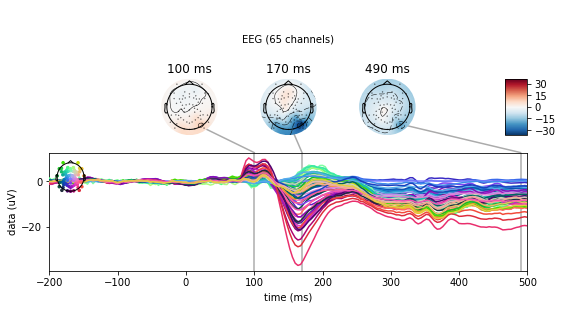

In [55]:
erp.plot_joint(times=[0.1, 0.17, 0.49]);

In [ ]:
# tutaj ICA - daj znać prowadzącemu :)